_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [2]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

In [3]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [4]:
target = df['shot_made_flag']
majority_value = target.mode()[0]
majority_value

0

In [5]:
from sklearn.metrics import accuracy_score

y_pred = [majority_value] * len(df)
train_acc = accuracy_score(target, y_pred)
print(f'The training majority baseline is {train_acc*100:.02f}%')

The training majority baseline is 52.71%


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [6]:
mask = (df['game_date'] > '2018-10-1') & (df['game_date'] <= '2019-6-31')

In [7]:
test = df.loc[mask]
test

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
12249,21800002,10,Stephen Curry,1,11,31,Step Back Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,226,90,1,2018-10-16,GSW,OKC,Regular Season,0.0
12250,21800002,58,Stephen Curry,1,7,57,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-2,63,1,2018-10-16,GSW,OKC,Regular Season,4.0
12251,21800002,131,Stephen Curry,1,3,46,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,5,29,1,2018-10-16,GSW,OKC,Regular Season,4.0
12252,21800002,141,Stephen Curry,1,2,58,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-6,18,0,2018-10-16,GSW,OKC,Regular Season,7.0
12253,21800002,145,Stephen Curry,1,2,49,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-228,8,1,2018-10-16,GSW,OKC,Regular Season,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0


In [8]:
train = df[~mask]

In [9]:
train

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12244,41700404,582,Stephen Curry,4,6,19,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,24,-240,0,1,2018-06-08,CLE,GSW,Playoffs,25.0
12245,41700404,588,Stephen Curry,4,5,48,Driving Floating Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,14,-115,89,0,2018-06-08,CLE,GSW,Playoffs,28.0
12246,41700404,591,Stephen Curry,4,5,13,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,34,-116,330,0,2018-06-08,CLE,GSW,Playoffs,26.0
12247,41700404,603,Stephen Curry,4,4,27,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,14,11,0,2018-06-08,CLE,GSW,Playoffs,25.0


## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [10]:
train['seconds_in_period_remaining'] = (train['minutes_remaining'] * 60) + train['seconds_remaining']
test['seconds_in_period_remaining'] = (test['minutes_remaining'] * 60) + test['seconds_remaining']

/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
test['seconds_in_period_remaining']

12249    691
12250    477
12251    226
12252    178
12253    169
        ... 
13953    481
13954    436
13955    327
13956    290
13957    167
Name: seconds_in_period_remaining, Length: 1709, dtype: int64

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [12]:
train, val = train_test_split(train, train_size= 0.861, random_state=42)

In [13]:
train

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,seconds_in_period_remaining
5147,21300899,26,Stephen Curry,1,9,24,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,22,174,138,0,2014-03-04,IND,GSW,Regular Season,-2.0,564
9004,41500144,19,Stephen Curry,1,9,45,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,25,159,203,0,2016-04-24,HOU,GSW,Playoffs,-1.0,585
7825,21500300,250,Stephen Curry,2,2,45,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),...,15,84,129,1,2015-12-06,BKN,GSW,Regular Season,9.0,165
7738,21500236,123,Stephen Curry,1,0,3,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,1,-17,-1,0,2015-11-27,PHX,GSW,Regular Season,17.0,3
3884,41200161,190,Stephen Curry,2,7,19,Jump Shot,2PT Field Goal,Mid-Range,Center(C),...,17,-34,168,0,2013-04-20,DEN,GSW,Playoffs,4.0,439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,41700233,112,Stephen Curry,1,2,32,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),...,25,-16,258,0,2018-05-04,NOP,GSW,Playoffs,-13.0,152
5191,21300942,289,Stephen Curry,3,8,42,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),...,25,-18,254,0,2014-03-09,GSW,PHX,Regular Season,-1.0,522
5390,21301141,372,Stephen Curry,3,2,45,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,18,-128,132,0,2014-04-04,GSW,SAC,Regular Season,33.0,165
860,20900982,295,Stephen Curry,3,9,35,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),...,22,-228,20,1,2010-03-13,GSW,TOR,Regular Season,3.0,575


In [14]:
val

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,seconds_in_period_remaining
5026,21300788,375,Stephen Curry,3,0,1,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),...,25,0,254,1,2014-02-12,GSW,MIA,Regular Season,-5.0,1
6676,21400999,2,Stephen Curry,1,11,44,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,22,99,203,0,2015-03-16,GSW,LAL,Regular Season,0.0,704
9794,21600405,84,Stephen Curry,1,3,20,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,2,-1,23,1,2016-12-17,GSW,POR,Regular Season,9.0,200
5577,41300166,57,Stephen Curry,1,6,5,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,1,13,12,1,2014-05-01,GSW,LAC,Playoffs,-7.0,365
9399,21600054,405,Stephen Curry,3,1,11,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,22,102,198,0,2016-11-01,POR,GSW,Regular Season,23.0,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536,21200036,503,Stephen Curry,3,0,59,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,26,143,227,0,2012-11-03,LAC,GSW,Regular Season,6.0,59
6504,21400838,81,Stephen Curry,1,4,42,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,18,-116,142,1,2015-02-24,WAS,GSW,Regular Season,-5.0,282
4189,21300091,197,Stephen Curry,2,5,25,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),...,23,231,-13,1,2013-11-09,MEM,GSW,Regular Season,-8.0,325
3422,21200853,491,Stephen Curry,4,3,42,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,24,207,140,1,2013-02-27,NYK,GSW,Regular Season,-2.0,222


## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [26]:
target = 'shot_made_flag'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)



# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop('shot_made_flag', axis=1)

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', accuracy_score(y_val, y_pred))

# 

Train Accuracy 1.0
Validation Accuracy 0.5904037448800468


## 6.Get your model's validation accuracy

Done above

## 7. Get your model's test accuracy

> (One time, at the end.)

In [25]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Test Accuracy', accuracy_score(y_val, y_pred))

Train Accuracy 1.0
Test Accuracy 0.4909303686366296


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

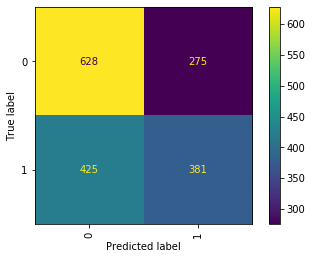

In [27]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

### Calculate accuracy 

In [32]:
correct_predictions = 628 + 381
correct_predictions

1009

In [33]:
total_predictions = 628 + 425 + 381 + 275
total_predictions

1709

In [34]:
print('Accuracy: ')
correct_predictions / total_predictions

Accuracy: 


0.5904037448800468

### Calculate precision

### Calculate recall

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.70      0.64       903
           1       0.58      0.47      0.52       806

    accuracy                           0.59      1709
   macro avg       0.59      0.58      0.58      1709
weighted avg       0.59      0.59      0.59      1709

